# Active Hopper(Ground)

In [42]:
import os
# Get current working directory
cwd = os.getcwd()

# Only go up one level if we’re currently inside 'notebooks'
if cwd.endswith("notebooks"):
    os.chdir("..")
print("Current working directory:", os.getcwd())

Current working directory: /Users/jerrywu/Desktop/hopper_sim


In [43]:
import yaml

with open("cfg/simple_active_hopper.yaml", "r") as f:
    cfg = yaml.safe_load(f)

m_b = cfg["body_mass"]
m_l = cfg["leg_mass"]
l0 = cfg["spring_length"]
g = cfg["gravity"]
x0 = cfg["x0"]
kp = cfg["kp"]
kd = cfg["kd"]


In [44]:
print(f"Body mass: {m_b}, Leg mass: {m_l}, Spring length: {l0}, Gravity: {g}, kp: {kp}, kd: {kd},  Initial state: {x0}")

Body mass: 1, Leg mass: 0.2, Spring length: 0.3, Gravity: 9.81, kp: 500, kd: 50,  Initial state: [1, -0.1, 0.9, 0.0]


## Two States State Machine

Initial state: flight


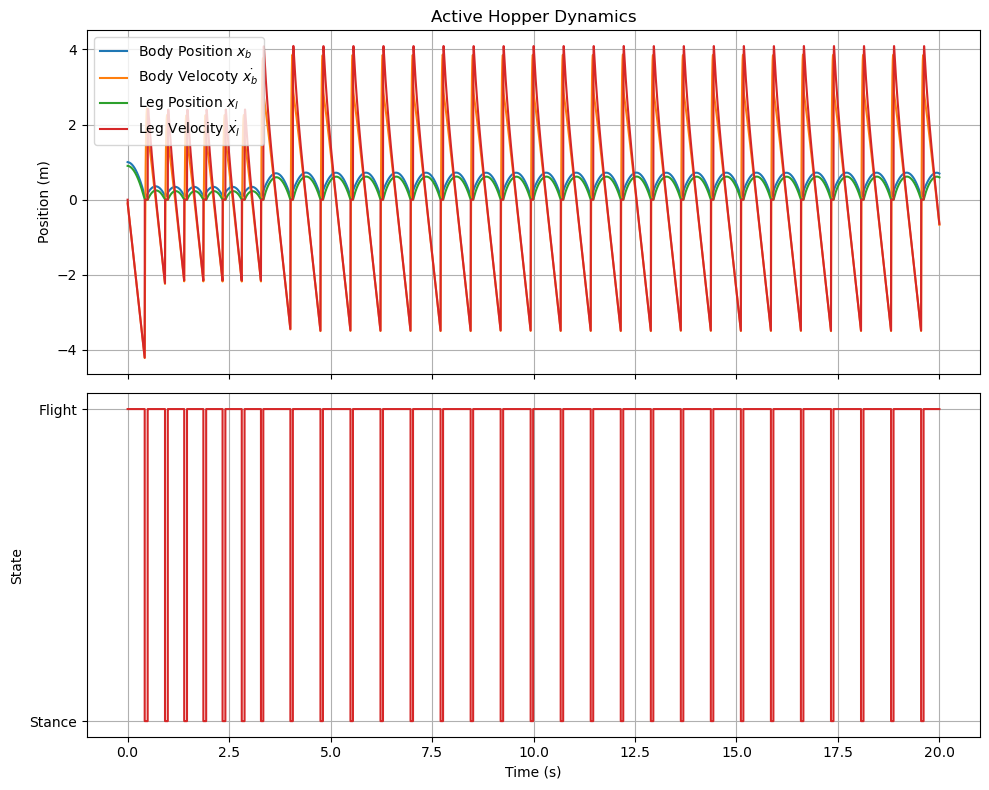

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from models.simple_active_hopper import flight_state, stance_state
from models.simple_active_hopper import PDController

# --- Simulation ---
dt = 0.001
t_max = 20.0
steps = int(t_max / dt)
t = np.linspace(0, t_max, steps)

# initial state
x = np.zeros((steps, 4))
x[0] = x0

if x0[2] > 0:
    state = "flight"
else:
    state = "stance"

print(f"Initial state: {state}")
# Store state (0 = stance, 1 = flight)
state_arr = np.zeros(steps)
state_arr[0] = 1 if state == "flight" else 0

# Create PD controller
controller = PDController(kp=kp, kd=kd)


for i in range(1, steps):
    t_curr = t[i]
    
 
    if t_curr < 3.0:
        l_ref_flight = 0.1   # pull leg up more
        l_ref_stance = 0.4   # medium hop
    else:
        l_ref_flight = 0.10   # return to calm rhythm
        l_ref_stance = 0.6

    # ---- Select controller reference based on state ----
    if state == "flight":
        l_ref = l_ref_flight
    else:  # stance
        l_ref = l_ref_stance

    ldot_ref = 0.0

    u = controller.compute(x[i-1], l_ref, ldot_ref)

    if state == "flight":
        x_dot, F_sub = flight_state(x[i-1], m_b, m_l, g, u)
        x[i] = x[i-1] + x_dot * dt

        # touchdown
        if x[i-1][2] > 0 and x[i][2] <= 0 and x[i-1][3] < 0:
            x[i][2] = 0.0
            x[i][3] = 0.0
            state = "stance"

    elif state == "stance":
        x_dot, F_sub = stance_state(x[i-1], m_b, m_l, g, u)
        x[i] = x[i-1] + x_dot * dt

        # lift-off
        if F_sub <= 0 and x[i][1] > 0:
            state = "flight"

    state_arr[i] = 1 if state == "flight" else 0


# --- Plotting ---
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Trajectories
axs[0].plot(t, x[:, 0], label='Body Position $x_b$')
axs[0].plot(t, x[:, 1], label='Body Velocoty $\dot{x_b}$')
axs[0].plot(t, x[:, 2], label='Leg Position $x_l$')
axs[0].plot(t, x[:, 3], label='Leg Velocity $\dot{x_l}$')
axs[0].set_ylabel('Position (m)')
axs[0].set_title('Active Hopper Dynamics')
axs[0].legend()
axs[0].grid(True)

# State transitions (flight = 1, stance = 0)
axs[1].plot(t, state_arr, color='tab:red', drawstyle='steps-post')
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('State')
axs[1].set_yticks([0, 1])
axs[1].set_yticklabels(['Stance', 'Flight'])
axs[1].grid(True)

plt.tight_layout()
plt.show()

## PyBullet Visualization

In [46]:
# import pybullet as p
# import pybullet_data
# import time
# import numpy as np

# # Assumes x, t, state_arr, dt are already defined from your simulation
# # x[:,0] = body pos, x[:,2] = leg pos, state_arr ∈ {0 (stance), 1 (flight)}

# p.connect(p.GUI)
# p.setAdditionalSearchPath(pybullet_data.getDataPath())
# p.setGravity(0, 0, -9.81)

# # Slightly lower plane so body never visually penetrates
# plane = p.loadURDF("plane.urdf", [0, 0, -0.02])

# # --- Visual parameters ---
# h_body = 0.05   # half height of body
# h_leg  = 0.025  # half height of leg (smaller)
# spring_color = [0, 1, 0]  # green

# # --- Create shapes ---
# body_visual = p.createVisualShape(p.GEOM_BOX, halfExtents=[h_body, h_body, h_body], rgbaColor=[0, 0, 1, 1])
# leg_visual  = p.createVisualShape(p.GEOM_BOX, halfExtents=[h_leg,  h_leg,  h_leg],  rgbaColor=[1, 0.5, 0, 1])
# body_col    = p.createCollisionShape(p.GEOM_BOX, halfExtents=[h_body, h_body, h_body])
# leg_col     = p.createCollisionShape(p.GEOM_BOX, halfExtents=[h_leg,  h_leg,  h_leg])

# # --- Create rigid bodies (visual only) ---
# body = p.createMultiBody(baseMass=1,
#                          baseCollisionShapeIndex=body_col,
#                          baseVisualShapeIndex=body_visual,
#                          basePosition=[0, 0, x[0, 0] + h_body])

# leg = p.createMultiBody(baseMass=1,
#                         baseCollisionShapeIndex=leg_col,
#                         baseVisualShapeIndex=leg_visual,
#                         basePosition=[0, 0, x[0, 2] + h_leg])

# # --- Animation loop ---
# try:
#     while True:
#         start_time = time.time()
#         for i in range(len(t)):
#             # --- Get states ---
#             z_body = x[i, 0]
#             z_leg  = x[i, 2]
#             in_flight = state_arr[i] > 0.5

#             # --- Ground lock: leg stays at z=0 during stance ---
#             if not in_flight:
#                 z_leg = 0.0

#             # --- Set new visual positions ---
#             p.resetBasePositionAndOrientation(body, [0, 0, z_body + h_body], [0, 0, 0, 1])
#             p.resetBasePositionAndOrientation(leg, [0, 0, z_leg + h_leg], [0, 0, 0, 1])

#             # --- Draw spring (only in stance) ---
#             p.removeAllUserDebugItems()
#             if not in_flight:
#                 p.addUserDebugLine(
#                     [0, 0, z_leg + h_leg],
#                     [0, 0, z_body + h_body],
#                     spring_color, 2, dt
#                 )

#             # --- Real-time sync ---
#             target_time = start_time + t[i]
#             sleep_time = target_time - time.time()
#             if sleep_time > 0:
#                 time.sleep(sleep_time)

# except KeyboardInterrupt:
#     print("\nAnimation stopped.")
#     p.disconnect()